# Run selection demonstration

Jelle, updated May 2020

Run selection in strax is relatively simple. Let's start with setting up a basic XENON1T analysis:

In [1]:
import strax
import straxen

st = straxen.contexts.xenon1t_dali()

### 1. Basic selections

Suppose we want to select runs that satisfy all of these criteria:
  * Have a tag called `sciencerun2_preliminary` (or `_sciencerun2_preliminary`, we ignore leading underscores)
  * Do NOT have tags `afterNG` or `AfterNG`, indicating the run was shortly after a neutron generator. 
  * Have `raw_records` accessible.
  * Have a run mode that starts with `background` (e.g. `background_stable` and `background_triggerless`)
  
Here's how you would do that:

In [2]:
dsets = st.select_runs(include_tags='sciencerun2_preliminary', 
                       exclude_tags='?fterNG',
                       available='raw_records', 
                       run_mode='background*')
len(dsets)

Checking data availability: 100%|██████████| 5/5 [00:18<00:00,  3.78s/it]


40

The first time you run the cell above, it took a few seconds to fetch some information from the XENON runs db. If you run it again, or if you run some other selection, it won't have to (try it), and should return almost instantly.

The results are returned as a dataframe:

In [3]:
dsets.head()

,name,number,start,reader.ini.name,trigger.events_built,end,tags,mode,livetime,tags.name,peaklets_available,raw_records_available,events_available,event_info_available,records_available
141,180215_1029,16854,2018-02-15 10:29:52+00:00,background_triggerless,858,2018-02-15 10:30:55+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",background_triggerless,00:01:03,NaN,True,True,True,True,True
142,180215_1035,16855,2018-02-15 10:35:42+00:00,background_triggerless,36292,2018-02-15 11:35:45+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",background_triggerless,01:00:03,NaN,True,True,True,True,True
143,180216_1324,16887,2018-02-16 13:24:43+00:00,background_triggerless,36292,2018-02-16 14:24:47+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",background_triggerless,01:00:04,NaN,True,True,True,True,True
144,180216_1455,16889,2018-02-16 14:55:06+00:00,background_triggerless,36292,2018-02-16 15:55:09+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",background_triggerless,01:00:03,NaN,True,True,True,True,True
145,180216_1625,16891,2018-02-16 16:25:26+00:00,background_triggerless,36292,2018-02-16 17:25:29+00:00,"_sciencerun2_candidate,_sciencerun2_preliminary",background_triggerless,01:00:03,NaN,True,True,True,True,True


In particular, the `name` field gives the `run_id` you feed to `st.get_data`.

### 2. The `dsets` dataframe, more refined selections

The extra info in the `dsets` dataframe can be used for further selections, for example on the number of events or the start/stop times of the run.

In [4]:
dsets = dsets[dsets['trigger.events_built'] > 10000]
len(dsets)

39

You can also use it to get some quick statistics on the runs, such as the total uncorrected live-time:

In [5]:
(dsets['end'] - dsets['start']).sum()

Timedelta('1 days 15:02:09')

You might also want to check all combinations of tags that occur in the selected datasets, to see if anything odd is selected. Straxen has a utility function for this:

In [6]:
strax.count_tags(dsets)

Counter({'_sciencerun2_candidate': 39, '_sciencerun2_preliminary': 39})

Hmm, maybe you want to add `wrongtime` to the list of excluded tags. Try it!

### 3. Detailed run info and advanced selections

If you want to get more detailed run information on a single run, you can use the `run_metadata` method to fetch the entire run document:

In [7]:
doc = st.run_metadata('180215_1029')
print(list(doc.keys()))

['name', 'user', 'detector', 'number', 'start', 'reader.ini.parent', 'reader.ini._id', 'reader.ini.date', 'reader.ini.nickname', 'reader.ini.trigger_config_override.Zip.events_per_file', 'reader.ini.trigger_config_override.Queues.max_blocks_on_heap', 'reader.ini.trigger_config_override.Trigger.event_separation', 'reader.ini.trigger_config_override.Trigger.signal_separation', 'reader.ini.trigger_config_override.Trigger.trigger_plugins', 'reader.ini.detector', 'reader.ini.user', 'reader.ini.name', 'reader.ini.source_type', 'reader.ini.comment', 'reader.ini.DDC-10.outer_ring_factor', 'reader.ini.DDC-10.prescaling', 'reader.ini.DDC-10.delay', 'reader.ini.DDC-10.required', 'reader.ini.DDC-10.rise_time_cut', 'reader.ini.DDC-10.component_status', 'reader.ini.DDC-10.window', 'reader.ini.DDC-10.parameter_1', 'reader.ini.DDC-10.parameter_3', 'reader.ini.DDC-10.parameter_2', 'reader.ini.DDC-10.integration_threshold', 'reader.ini.DDC-10.sign', 'reader.ini.DDC-10.parameter_0', 'reader.ini.DDC-10.ad

Please do not use this in a loop over all runs, the runs database is almost 1 GB in size... This may become smaller in the future, if we decide to put chunk-level metadata somewhere else.

If you want to get a specific piece of information for many runs, you can tell straxen to fetch extra fields from the runs db with `scan_runs`. Note this had to repeat the availability check. There is an open issue to make this faster: [#246](https://github.com/AxFoundation/strax/issues/246).

In [8]:
st.scan_runs(store_fields='quality.hv.anode')
dsets = st.select_runs(include_tags='sciencerun1')

Checking data availability: 100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


Now `dsets` has an extra column `quality__hv__anode` available that you can select on. We converted the dots (`.`) in the field name to double underscores (`__`) to ensure the column name remains a valid python identifier. Here's a histogram of the observed values:

In [9]:
dsets.columns

Index(['name', 'number', 'start', 'reader.ini.name', 'trigger.events_built',
       'end', 'tags', 'quality.hv.anode', 'mode', 'livetime', 'tags.name',
       'peaklets_available', 'raw_records_available', 'events_available',
       'event_info_available', 'records_available'],
      dtype='object')

Text(0, 0.5, 'Number of runs')

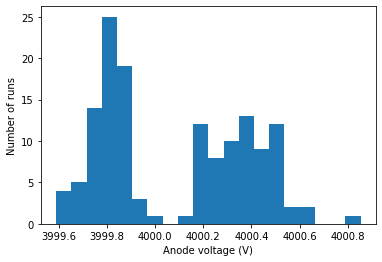

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(dsets['quality.hv.anode'], bins=20);
plt.ticklabel_format(useOffset=False)
plt.xlabel("Anode voltage (V)")
plt.ylabel("Number of runs")

Finally, if you want to do something truly custom, you can construct and run your own MongoDB query or aggregation.

TODO: For now this doesn't work in this context, since the actual XENON run db is not activated.

In [11]:
# mongo_collection = st.storage[0].collection
# doc = mongo_collection.find_one({'number': 10000}, projection=['name'])
# doc['name']